In [44]:
import os
import time

import numpy as np
import pickle
import scipy.io as scio
import torch
import torchvision.transforms.functional as transforms
from scipy import stats
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from thop import clever_format
from thop import profile
from sklearn import metrics
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab 

from dataset import monoSimDataset
from model.loss import FocalLoss, CrossEntropy2d
from model.quality_model import MobileNetV2_Lite_shower, MobileNetV3_wA, MobileNetV3_Lite, MobileNetV2_Lite

In [142]:
def cal_DET(sim, labels):
    label_num = len(labels)
    sim = sim[~np.eye(label_num, dtype=np.bool)]
    if labels.max() == 1 and labels.min() == 0 and labels.shape[0] != labels.shape[1]:
        label = np.dot(labels, labels.T)
    else:
        label = np.zeros((label_num, label_num))
        for x in range(label_num):
            for y in range(label_num):
                label[x, y] = labels[x] == labels[y]
    label = label[~np.eye(label_num, dtype=np.bool)].astype(np.bool)

    fpr, tpr, thresholds = metrics.roc_curve(label, sim)
    fnr = 1 - tpr

    eer = fpr[np.argmin(np.abs(fpr - fnr))]
    roc_auc = metrics.auc(fpr, tpr)
    return eer, fnr, fpr, roc_auc, thresholds

In [67]:
tj_dataset_path = '/home/dl/wangleyuan/dataset/TJ-Eyes'
sd_dataset_path = '/home/dl/wangleyuan/dataset/SD-Eyes'

cp_path = cp_path = "checkpoints/1203_202301_MobileNetV2_Lite/421_1.3395e-03.pth"
model_name = 'MobileNetV2_Lite'
seed = 2248
device = 'cuda:0'

In [8]:
with open(tj_dataset_path + '/test.txt','r') as f:
    tj_p_list = [x.strip().split(' ') for x in f.readlines()]
tj_index = {x[0]:(x[1],x[2]) for x in tj_p_list}
tj_sim = (scio.loadmat(tj_dataset_path + '/sim.mat')['sim'] +1)/2

with open(sd_dataset_path + '/test.txt','r') as f:
    sd_p_list = [x.strip().split(' ') for x in f.readlines()]
sd_index = {x[0]:(x[1],x[2]) for x in sd_p_list}
sd_sim = (scio.loadmat(sd_dataset_path + '/sim.mat')['sim'] +1)/2

In [16]:
tj_test_sim = np.zeros((len(tj_index), len(tj_index)))
for tx , d in enumerate(tj_p_list):
    sx = int(d[2])
    for ty, d in enumerate(tj_p_list):
        sy = int(d[2])
        tj_test_sim[tx, ty] = tj_sim[sx,sy]
tj_test_labels = np.array([int(x[1]) for x in tj_p_list])
eer, fnr, fpr, roc_auc, thresholds = cal_DET(tj_test_sim, tj_test_labels)
fnmr = fnr[np.argmin(np.abs(fpr - 1e-5))]
print('TJ All Test EER:{:.2f}% FNMR:{:.2f}%'.format(eer*100, fnmr*100))

sd_test_sim = np.zeros((len(sd_index), len(sd_index)))
for tx , d in enumerate(sd_p_list):
    sx = int(d[2])
    for ty, d in enumerate(sd_p_list):
        sy = int(d[2])
        sd_test_sim[tx, ty] = sd_sim[sx,sy]
sd_test_labels = np.array([int(x[1]) for x in sd_p_list])
eer, fnr, fpr, roc_auc, thresholds = cal_DET(sd_test_sim, sd_test_labels)
fnmr = fnr[np.argmin(np.abs(fpr - 1e-5))]
print('SD All Test EER:{:.2f}% FNMR:{:.2f}%'.format(eer*100, fnmr*100))

TJ All Test EER:28.59% FNMR:100.00%
SD All Test  EER:12.41% FNMR:100.00%


In [15]:
with open(sd_dataset_path + '/hq.txt','r') as f:
    sd_hq_set = set([x.split(' ')[0] for x in f.readlines()])
sd_hq_names = [x[0] for x in sd_p_list if x[0] in sd_hq_set]

sd_test_sim = np.zeros((len(sd_hq_names), len(sd_hq_names)))
for tx , d in enumerate(sd_hq_names):
    sx = int(sd_index[d][1])
    for ty, d in enumerate(sd_hq_names):
        sy = int(sd_index[d][1])
        sd_test_sim[tx, ty] = sd_sim[sx,sy]
sd_test_labels = np.array([int(sd_index[x][0]) for x in sd_hq_names])
eer, fnr, fpr, roc_auc, thresholds = cal_DET(sd_test_sim, sd_test_labels)
fnmr = fnr[np.argmin(np.abs(fpr - 1e-5))]
print('SD All Test EER:{:.2f}% FNMR:{:.2f}%'.format(eer*100, fnmr*100))

SD All Test EER:1.28% FNMR:100.00%


In [18]:
tj_hq_names = [x[0] for x in tj_p_list if x[0][8] == '1']
print(len(tj_hq_names))

tj_test_sim = np.zeros((len(tj_hq_names), len(tj_hq_names)))
for tx , d in enumerate(tj_hq_names):
    sx = int(tj_index[d][1])
    for ty, d in enumerate(tj_hq_names):
        sy = int(tj_index[d][1])
        tj_test_sim[tx, ty] = tj_sim[sx,sy]
tj_test_labels = np.array([int(tj_index[x][0]) for x in tj_hq_names])
eer, fnr, fpr, roc_auc, thresholds = cal_DET(tj_test_sim, tj_test_labels)
fnmr = fnr[np.argmin(np.abs(fpr - 1e-5))]
print('TJ All Test EER:{:.2f}% FNMR:{:.2f}%'.format(eer*100, fnmr*100))

92
TJ All Test EER:16.46% FNMR:100.00%


92


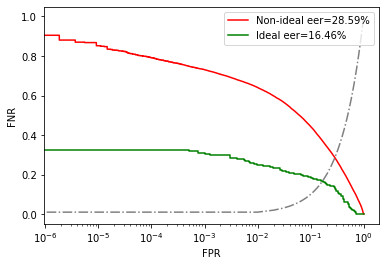

In [154]:
plt.figure()
tj_test_sim = np.zeros((len(tj_index), len(tj_index)))
for tx , d in enumerate(tj_p_list):
    sx = int(d[2])
    for ty, d in enumerate(tj_p_list):
        sy = int(d[2])
        tj_test_sim[tx, ty] = tj_sim[sx,sy]
tj_test_labels = np.array([int(x[1]) for x in tj_p_list])
eer1, fnr1, fpr1, roc_auc, thresholds = cal_DET(tj_test_sim, tj_test_labels)


tj_hq_names = [x[0] for x in tj_p_list if x[0][8] == '1']
print(len(tj_hq_names))

tj_test_sim = np.zeros((len(tj_hq_names), len(tj_hq_names)))
for tx , d in enumerate(tj_hq_names):
    sx = int(tj_index[d][1])
    for ty, d in enumerate(tj_hq_names):
        sy = int(tj_index[d][1])
        tj_test_sim[tx, ty] = tj_sim[sx,sy]
tj_test_labels = np.array([int(tj_index[x][0]) for x in tj_hq_names])
eer2, fnr2, fpr2, roc_auc, thresholds = cal_DET(tj_test_sim, tj_test_labels)

plt.plot(fpr1,fnr1,c='r',label='Non-ideal eer={:.2f}%'.format(eer1*100))
plt.plot(fpr2,fnr2,c='g',label='Ideal eer={:.2f}%'.format(eer2*100))
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.legend(loc = 'upper right')
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01),linestyle='-.',c='gray',label='eer')
plt.show()

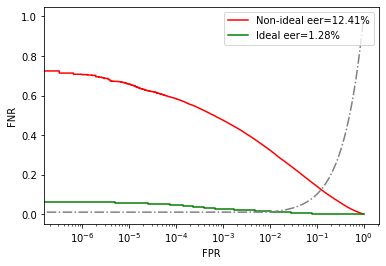

In [155]:
sd_test_sim = np.zeros((len(sd_index), len(sd_index)))
for tx , d in enumerate(sd_p_list):
    sx = int(d[2])
    for ty, d in enumerate(sd_p_list):
        sy = int(d[2])
        sd_test_sim[tx, ty] = sd_sim[sx,sy]
sd_test_labels = np.array([int(x[1]) for x in sd_p_list])
eer1, fnr1, fpr1, roc_auc, thresholds = cal_DET(sd_test_sim, sd_test_labels)

sd_test_sim = np.zeros((len(sd_hq_names), len(sd_hq_names)))
for tx , d in enumerate(sd_hq_names):
    sx = int(sd_index[d][1])
    for ty, d in enumerate(sd_hq_names):
        sy = int(sd_index[d][1])
        sd_test_sim[tx, ty] = sd_sim[sx,sy]
sd_test_labels = np.array([int(sd_index[x][0]) for x in sd_hq_names])
eer2, fnr2, fpr2, roc_auc, thresholds = cal_DET(sd_test_sim, sd_test_labels)

plt.plot(fpr1,fnr1,c='r',label='Non-ideal eer={:.2f}%'.format(eer1*100))
plt.plot(fpr2,fnr2,c='g',label='Ideal eer={:.2f}%'.format(eer2*100))
plt.xscale('log')
plt.xlabel('FPR')
plt.ylabel('FNR')
plt.legend(loc = 'upper right')
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01),linestyle='-.',c='gray',label='eer')
plt.show()

In [19]:
with open('tj_train_quality.txt', 'r') as f:
    qdata = [x.strip() for x in f.readlines()]
qdict = {x.split(',')[0]:[float(y) for y in x.split(',')[1].split(' ')[1:]] for x in qdata}

qarray = np.zeros((len(qdict),5))
for idx,n in enumerate(qdict.keys()):
    qarray[idx,:] = np.array(qdict[n])

tj_fm = qarray[:, 0]
tj_size = qarray[:, 1]
tj_dilation = qarray[:, 2]
tj_gls = qarray[:, 3]
tj_uar = qarray[:, 4]

with open('sd_train_quality.txt', 'r') as f:
    qdata = [x.strip() for x in f.readlines()]
qdict = {x.split(',')[0]:[float(y) for y in x.split(',')[1].split(' ')[1:]] for x in qdata}

qarray = np.zeros((len(qdict),5))
for idx,n in enumerate(qdict.keys()):
    qarray[idx,:] = np.array(qdict[n])

sd_fm = qarray[:, 0]
sd_size = qarray[:, 1]
sd_dilation = qarray[:, 2]
sd_gls = qarray[:, 3]
sd_uar = qarray[:, 4]

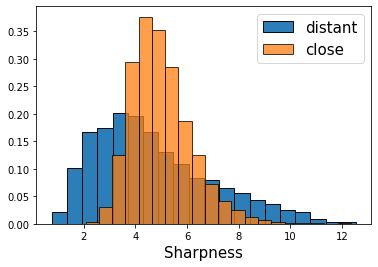

In [36]:
sd_mu = np.mean(sd_fm)
sd_sigma = np.std(sd_fm)
tj_mu = np.mean(tj_fm)
tj_sigma = np.std(tj_fm)

tj_count, tj_bins, _ = plt.hist(tj_fm,bins=20, edgecolor='k', density=True,alpha=0.95, label='distant')
sd_count, sd_bins, _ = plt.hist(sd_fm,bins=20, edgecolor='k', density=True,alpha=0.75, label='close')

plt.xlabel('Sharpness', fontsize=15)
plt.legend(fontsize=15)

# plt.plot(tj_bins, 1./(np.sqrt(2*np.pi)*tj_sigma)*np.exp(-(tj_bins-tj_mu)**2/(2*tj_sigma**2)), lw=2, c='b')
# plt.plot(sd_bins, 1./(np.sqrt(2*np.pi)*sd_sigma)*np.exp(-(sd_bins-tj_mu)**2/(2*sd_sigma**2)), lw=2, c='r')

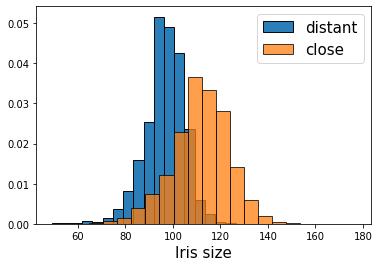

In [37]:
tj_count, tj_bins, _ = plt.hist(tj_size,bins=20, edgecolor='k', density=True,alpha=0.95, label='distant')
sd_count, sd_bins, _ = plt.hist(sd_size,bins=20, edgecolor='k', density=True,alpha=0.75, label='close')

plt.xlabel('Iris size', fontsize=15)
plt.legend(fontsize=15)

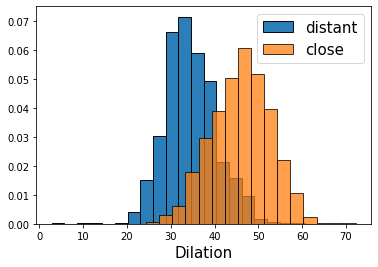

In [38]:
tj_count, tj_bins, _ = plt.hist(tj_dilation,bins=20, edgecolor='k', density=True,alpha=0.95, label='distant')
sd_count, sd_bins, _ = plt.hist(sd_dilation,bins=20, edgecolor='k', density=True,alpha=0.75, label='close')

plt.xlabel('Dilation', fontsize=15)
plt.legend(fontsize=15)

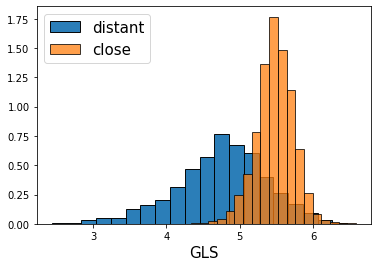

In [39]:
tj_count, tj_bins, _ = plt.hist(tj_gls,bins=20, edgecolor='k', density=True,alpha=0.95, label='distant')
sd_count, sd_bins, _ = plt.hist(sd_gls,bins=20, edgecolor='k', density=True,alpha=0.75, label='close')

plt.xlabel('GLS', fontsize=15)
plt.legend(fontsize=15)

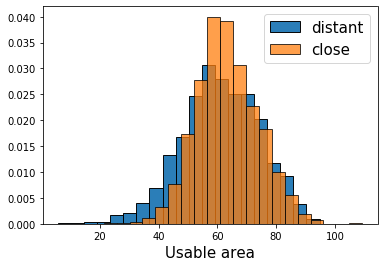

In [40]:
tj_count, tj_bins, _ = plt.hist(tj_uar,bins=20, edgecolor='k', density=True,alpha=0.95, label='distant')
sd_count, sd_bins, _ = plt.hist(sd_uar,bins=20, edgecolor='k', density=True,alpha=0.75, label='close')

plt.xlabel('Usable area', fontsize=15)
plt.legend(fontsize=15)

In [68]:
test_data = monoSimDataset(path=sd_dataset_path, mode='test', seed=seed, debug_data=False,upsample=True)

model = MobileNetV2_Lite_shower(True, True, 0.5)
assert model is not None
model.to('cpu')
assert cp_path is not ''
cp_data = torch.load(cp_path, map_location=device)
try:
    model.load_state_dict(cp_data['model'])
except Exception as e:
    model.load_state_dict(cp_data['model'], strict=False)
    print(e)

cp_data['cfg'] = '' if 'cfg' not in cp_data else cp_data['cfg']
print(cp_data['cfg'])

info=v2 multi_linear sim 0~1 adam l1loss
dataset_path=/home/dl/wangleyuan/dataset/SD-Eyes
cp_path=
cp_num=5
visible=True
model=MobileNetV2_Lite
seed=2248
debug=False
mask_learn_rate=0.003125
mask_lr_decay=0.5
upout=True
batch_size=24
device=cuda:2
num_workers=2
max_epochs=500
lr=0.0004
momentum=0.9
weight_decay=0.0005
name=1203_202301_MobileNetV2_Lite



In [69]:
img, mask, target, name = test_data[15]
img_tensor = torch.unsqueeze(img, 0).to('cpu')
mask_tensor = torch.unsqueeze(mask, 0)
print(img_tensor.shape)
print(name,target)

# img = transforms.to_pil_image(img)
# mask = transforms.to_pil_image(mask*255)
# plt.imshow(mask, cmap ='gray')
# mask_tensor.max()

torch.Size([1, 3, 480, 640])
0002_2_1_2_22_005.bmp tensor([0.7646])


In [125]:
pred, heatmap, short, feat = model(img_tensor)
model.eval()
print(pred.shape, heatmap.shape, short.shape, feat.shape)

torch.Size([1, 1]) torch.Size([1, 2, 120, 160]) torch.Size([1, 32, 60, 80]) torch.Size([1, 1280, 15, 20])


(-0.5, 159.5, 119.5, -0.5)

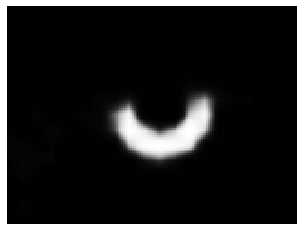

In [127]:
heatmap = torch.softmax(heatmap, 1)
heatmap_img = transforms.to_pil_image(heatmap[0,0,:,:])
plt.imshow(heatmap_img, cmap='gray_r')
plt.axis('off')

(-0.5, 79.5, 59.5, -0.5)

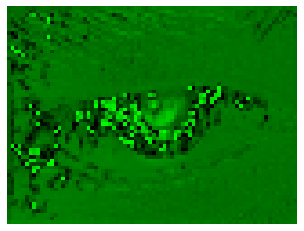

In [133]:
idx = 5
short1 = transforms.to_pil_image(short[0,idx:idx+3,:,:])
plt.imshow(short1)
plt.axis('off')

tensor([965, 846, 533])


(-0.5, 19.5, 14.5, -0.5)

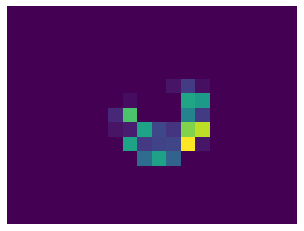

In [138]:

featsum,index = torch.topk(feat[0].sum((1,2)), 7)
print(index[-3:])
idx = index[-1]
feat1 = transforms.to_pil_image(feat[0,idx,:,:])
plt.imshow(feat1)
plt.axis('off')